# Initialization

Automatically search for an NVIDIA GPU and use it. If not, then use CPU

In [1]:
import torch


if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')

Using GPU


Load all of our preprocessed and split data from our cache

In [2]:
import pickle


# Label to use for this model in the plots
model_name = 'CGCNN'

with open('../preprocessing/sdt/gasdb/feature_dimensions.pkl', 'rb') as file_handle:
    orig_atom_fea_len, nbr_fea_len = pickle.load(file_handle)

with open('../preprocessing/splits_gasdb.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)

docs_train = splits['docs_train']
docs_val = splits['docs_val']
sdts_train, sdts_val = splits['sdts_train'], splits['sdts_val']
targets_train, targets_val = splits['targets_train'], splits['targets_val']

# Where we put the intermediate results for this notebook
prefix = 'gasdb_pooled/'

Initialize the CGCNN `net` class

In [3]:
from torch.optim import Adam
import skorch.callbacks.base
from skorch import callbacks  # needs skorch >= 0.4  
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from cgcnn.model import CrystalGraphConvNet
from cgcnn.data import collate_pool, MergeDataset


# Callback to checkpoint parameters every time there is a new best for validation loss
cp = callbacks.Checkpoint(monitor='valid_loss_best', fn_prefix=prefix+'valid_best_')

# Callback to load the checkpoint with the best validation loss at the end of training
class train_end_load_best_valid_loss(callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params(prefix+'valid_best_params.pt')
load_best_valid_loss = train_end_load_best_valid_loss()

# Callback to set the learning rate dynamically
LR_schedule = callbacks.lr_scheduler.LRScheduler('MultiStepLR', milestones=[100], gamma=0.1)

net = NeuralNetRegressor(
    CrystalGraphConvNet,
    module__orig_atom_fea_len=orig_atom_fea_len,
    module__nbr_fea_len=nbr_fea_len,
    batch_size=214,
    module__classification=False,
    lr=0.0056,
    max_epochs=150,
    module__atom_fea_len=46,
    module__h_fea_len=83,
    module__n_conv=8,
    module__n_h=4,
    optimizer=Adam,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__collate_fn=collate_pool,
    iterator_train__shuffle=True,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn=collate_pool,
    iterator_valid__shuffle=False,
    device=device,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    callbacks=[cp, load_best_valid_loss, LR_schedule]
)

# Training

We can train a new model...

In [4]:
net.initialize()
net.fit(sdts_train, targets_train)

Re-initializing module because the following parameters were re-set: atom_fea_len, classification, h_fea_len, n_conv, n_h, nbr_fea_len, orig_atom_fea_len.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
      1        0.5009        0.6553     +  59.8960
      2        0.4197        0.3540     +  58.5379
      3        0.3834        0.3511     +  58.6165
      4        0.3316        0.3835        58.6248
      5        0.3368        0.3561        58.5757
      6        0.3086        0.3283     +  58.5318
      7        0.3136        0.3199     +  58.5558
      8        0.2805        0.3551        58.5650
      9        0.2957        0.2888     +  58.5911
     10        0.3006        0.2724     +  58.5205
     11        0.2810        0.3039        58.5369
     12        0.2723        0.3038        58.6751
     13        0.2634        0.2776        58.5675
     14        0.2684        0.2763        58.5559
  

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=CrystalGraphConvNet(
    (embedding): Linear(in_features=98, out_features=46, bias=True)
    (convs): ModuleList(
      (0): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(beta=1, threshold=20)
      )
      (1): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(

In [ ]:
# Restart training in case first round was cut off
net.partial_fit(sdts_train, targets_train)

...or load whatever is cached

In [4]:
net.initialize()
net.load_params(f_history=prefix+'valid_best_history.json',
                f_optimizer=prefix+'valid_best_optimizer.pt', 
                f_params=prefix+'valid_best_params.pt')

# Assess performance

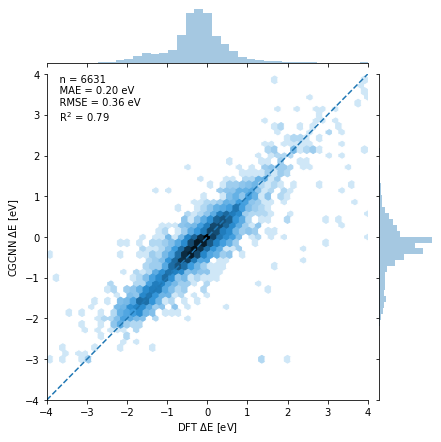

In [5]:
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns


# Make predictions
targets_pred = net.predict(sdts_val).reshape(-1)

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_val.reshape(-1), targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims+lims)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_val, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_val, targets_pred))
r2 = r2_score(targets_val, targets_pred)

# Report
text = ('    n = %i\n'
        '    MAE = %.2f eV\n'
        '    RMSE = %.2f eV\n'
        '    R$^2$ = %.2f'
        % (len(targets_val), mae, rmse, r2))
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top')

## Results-by-adsorbate
Let's dig into details and see how our results turned out for each adsorbate. Note that this section shows the results from a single model trained on a pooled dataset. Only the performance metrics are partitioned by adsorbate.

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np


class SeabornFig2Grid():
    '''
    Credit goes to ImportanceOfBeingErnest on StackOverflow
    https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot
    '''

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

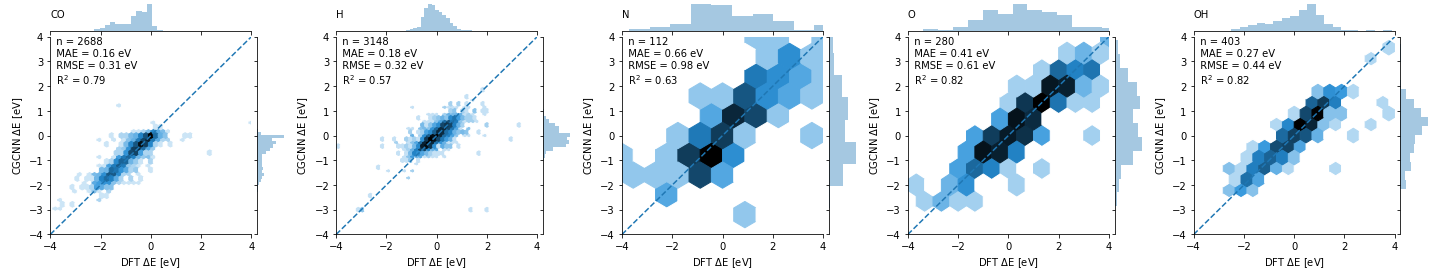

In [7]:
%matplotlib inline
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns


# Prepare figure for all adsorbates
adsorbates = list({doc['adsorbate'] for doc in docs_val})
adsorbates.sort()
fig = plt.figure(figsize=(20, 4))
gs = gridspec.GridSpec(1, len(adsorbates))

# Parse out the data for each adsorbate
for i, ads in enumerate(adsorbates):
    _targets_val = []
    _targets_pred = []
    for doc, target, pred in zip(docs_val, targets_val, targets_pred):
        if doc['adsorbate'] == ads:
            _targets_val.append(target)
            _targets_pred.append(pred)
    _targets_val = np.array(_targets_val).reshape(-1)
    _targets_pred = np.array(_targets_pred).reshape(-1)

    # Plot accuracy
    lims = [-4, 4]
    grid = sns.jointplot(_targets_val, _targets_pred,
                         kind='hex',
                         bins='log',
                         extent=lims*2)
    ax = grid.ax_joint
    _ = ax.set_xlim(lims)
    _ = ax.set_ylim(lims)
    _ = ax.plot(lims, lims, '--')
    _ = ax.set_xlabel('DFT $\Delta$E [eV]')
    _ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)
    _ = ax.set_title(ads)

    # Calculate + report metrics
    mae = mean_absolute_error(_targets_val, _targets_pred)
    rmse = np.sqrt(mean_squared_error(_targets_val, _targets_pred))
    r2 = r2_score(_targets_val, _targets_pred)
    grid.ax_marg_x.text(x=lims[0], y=0,
                        verticalalignment='bottom',
                        s='%s\n' % ads)
    text = ('  n = %i\n'
            '  MAE = %.2f eV\n'
            '  RMSE = %.2f eV\n'
            '  R$^2$ = %.2f'
            % (len(_targets_val), mae, rmse, r2))
    ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top')

    # Put the figure into the subplot
    sfg = SeabornFig2Grid(grid, fig, gs[i])
gs.tight_layout(fig)